## Filtros de Kalman
Basado en [ref](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/06_Multivariate_Kalman_Filters.ipynb)

Un filtro de Kalman es la generalización de los filtros probabilísticos vistos anteriormente cuando las relaciones entre las variables implicadas son lineales.

El principio de funcionamiento es el mismo: 

1. Hacemos una predicción sobre el estado de nuestro sistema en el siguiente estado de tiempo.
1. Combinamos la predicción anterior con la medición que hacemos del estado del sistema para tener una estimación del mismo.

Los filtros de Kalman nos van a permitir además manejar una casuística algo más compleja. Por ejemplo:

1. El estado de nuestro sistema puede contener variables que no son observadas directamente. Por ejemplo, cuando medimos la posición únicamente pero también modelamos la velocidad.
1. Las mediciones que realizamos necesitan transformaciones lineales antes de ser procesadas. Por ejemplo, si para medir una temperatura en realidad lo que medimos es un voltaje a través de una resistencia.
1. Si sabemos que existen dependencias o covarianzas en las distribuciones de probabilidad de las variables las podemos expresar.

Sin más preámbulo, un filtro de Kalman se formula de la siguiente manera:

$$
\begin{aligned}
\text{Predict Step}\\
\mathbf{x^-} &= \mathbf{F x} + \mathbf{B u}\;\;\;&(1) \\
\mathbf{P^-} &= \mathbf{FP{F}}^\mathsf{T} + \mathbf{Q}\;\;\;&(2) \\
\\
\text{Update Step}\\
\textbf{y} &= \mathbf{z} - \mathbf{H x^-} \;\;\;&(3)\\
\textbf{S} &= \mathbf{HP^-H}^\mathsf{T} + \mathbf{R} \;\;\;&(4)\\
\mathbf{K} &= \mathbf{P^-H}^\mathsf{T} \mathbf{S}^{-1}\;\;\;&(5) \\
\mathbf{x} &=\mathbf{x^-} +\mathbf{K\textbf{y}} \;\;\;&(6)\\
\mathbf{P} &= (\mathbf{I}-\mathbf{KH})\mathbf{P^-}\;\;\;&(7)
\end{aligned}
$$

En donde:


>- Usamos la notación $x^-$ para indicar que estamos haciendo una predicción de $x$.
>- $\mathbf{P}$ es la incertidumbre (covarianza) de nuestra predicción. 

>- $\mathbf{x}$ es el vector que representa el estado que queremos modelar. 
>- $\mathbf{F}$ es la matriz que usamos para realizar la predicción del estado de nuestro sistema desde un instante de tiempo anterior.

Por ejemplo, $\mathbf{x} =\begin{bmatrix}s \\ v\end{bmatrix}$, en donde $s$ es la posición unidimensional de nuestro sistema y $v$ su velocidad. Nuestra predicción en el siguiente instante de tiempo es que la posición se actualiza de acorde a la velocidad que queda constante. Es decir

$$s^- = s + v$$
$$v^- = v$$


Por lo tanto:

$$
\begin{aligned}
{\begin{bmatrix}s\\v\end{bmatrix}}^- &=\begin{bmatrix}1&1 \\ 0&1\end{bmatrix} \begin{bmatrix}s \\ v\end{bmatrix}
\end{aligned}
$$

Es decir $\mathbf{x}^- = \mathbf{Fx}$, con $\mathbf{F}=\begin{bmatrix}1&1 \\ 0&1\end{bmatrix}$

>- $\mathbf{z}$ es la medida que realizamos.
>- $\mathbf{H}$ es la función de medida, que transforma el estado del sistema en las unidades de medida.
>- $\mathbf{R}$ es el ruido de medida (imprecisión).

Siguiendo con el ejemplo anterior, nuestro estado $\mathbf{x}$ tiene una posición y una velocidad, pero en realidad somo medimos la velocidad ($\mathbf{z}$ es un escalar). Por lo tanto, para comparar la medición con nuestro estado nos fijamos sólo en la posición, La ecuación

$$\textbf{y} = \mathbf{z} - \mathbf{H x^-} \;\;\;(3)$$

mide la diferencia entre la preducción de nuestro modelo y la medición realizada:

$$\textbf{y} = \mathbf{z} - \begin{bmatrix}1&0\end{bmatrix} \begin{bmatrix}s \\v\end{bmatrix}$$

igualmente, como nuestra medida es un escalar (la posición) $\mathbf{R}$ también lo es. Si tuviéramos dos sensores, $\mathbf{z} \in \mathbb{R}^2$ y $\mathbf{R} \in \mathbb{R}^{2\times 2}$

>- $\mathbf{Q}$ es el ruído del proceso. Es decir, la variabilidad con la que nuestro sistema sigue el modelo especificado por $\mathbf{F}$. Por ejemplo, aunque establezcamos todos los elementros de control para que un robot vaya a 10 Km/h, seguramente no mantenga exactamente esa velocidad, por irregularidades en el terreno, en sus motores de tracción, etc. $\mathbf{Q}$ trata de capturar esa variabilidad. La expresión $\mathbf{P^-} = \mathbf{FP{F}}^\mathsf{T} + \mathbf{Q}$, únicamente proyecta $\mathbf{P}$ en el espacio de nuestro modelo físico y le añade la variabilidad del mismo ($\mathbf{Q}$).

La ganancia de Kalman se usa para combinar la predicción con la medida y:

$$K \propto \frac{incertidumbre_{predicción}}{incertidumbre_{medida}} $$

y también:

- $P$ es el ruido de predicción (más ruido significa más incertidumbre)
- $R$ es el ruido que creemos que tiene la medición
- $Q$ es el ruido del proceso (precisión del robot en mantener su curso)

### Observa las medidas de movimiento de dos robots en 1D
- el primero con una velocidad constante

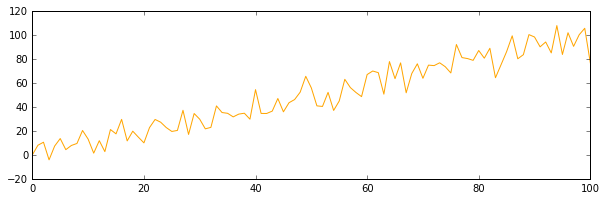

In [2]:
%run -i code/filter.py
%matplotlib inline
o = ConstantVelocityRobot(init_pos=0, vel=1, mnoise=10)
o.move_n_time_steps(100)
plt.figure(figsize=(10,3))
plt.plot(range(len(o.m_history)), o.m_history, label="measures", color="orange")
#plt.plot(range(len(o.m_history)), o.pos_history, lw=2, alpha=.5, label="real", color="red");


- y este con una aceleración constante

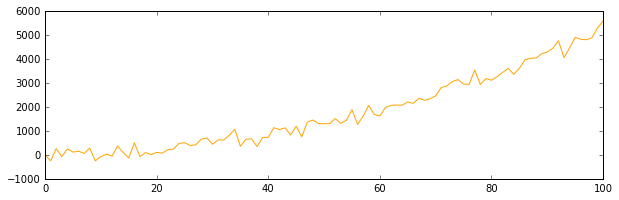

In [31]:
%run -i code/filter.py
o = ConstantAccelerationRobot(init_pos=0, init_vel=1, accel=1., mnoise=200)
o.move_n_time_steps(100)
plt.figure(figsize=(10,3))
plt.plot(range(len(o.m_history)), o.m_history, label="measures", color="orange")
#plt.plot(range(len(o.m_history)), o.pos_history, lw=2, alpha=.5, label="real", color="red");


### Observa ahora como un filtro de Kalman produce una estimación del movimiento desde las medidas tomadas del robot 1D con velocidad constante usando el modelo físico anterior

In [34]:
%run -i code/filter.py
%matplotlib inline

def plot_kalman1D(o, 
                  estimated_init_pos, estimated_init_vel,
                  P=1.,R=1.,Q=0.):

    F = np.array([[1, 1], [0, 1]])  # state transition matrix
    H = np.array([[1, 0]])          # Measurement function

    init_x = [np.array([estimated_init_pos]), np.array([estimated_init_vel])]

    k = KalmanFilter(dim_x=2, dim_z=1, P=P, R=R, Q=Q, F=F, H=H, init_x=init_x)
    xhist, Phist = k.filter_data(o.m_history)
    kalman_positions     = np.array([i[0] for i in xhist])[:,0]
    
    plt.figure(figsize=(10,3))
    plt.plot(range(len(xhist)), kalman_positions, lw=2, label="Kalman positions", color="black")
    plt.plot(range(len(o.m_history)), o.m_history, label="measures", color="orange")
    plt.plot(range(len(o.m_history)), o.pos_history, lw=5, alpha=.5, label="real", color="red");
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));


Observa una predicción de Kalman típica

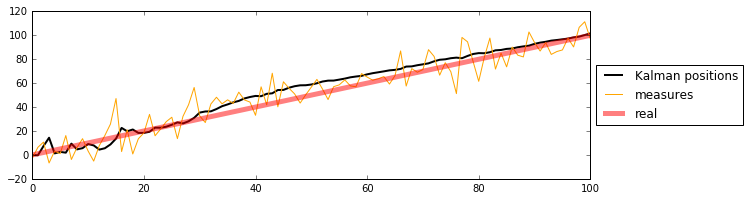

In [55]:
estimated_init_pos, estimated_init_vel  = 0., 1.

o = ConstantVelocityRobot(init_pos=0, vel=1, mnoise=10)
o.move_n_time_steps(100)
    
plot_kalman1D(o, estimated_init_pos, estimated_init_vel)

Incluso si las estimaciones iniciales de velocidad y posición son muy erróneas, siempre y cuando el modelo físico se corresponda a la realidad

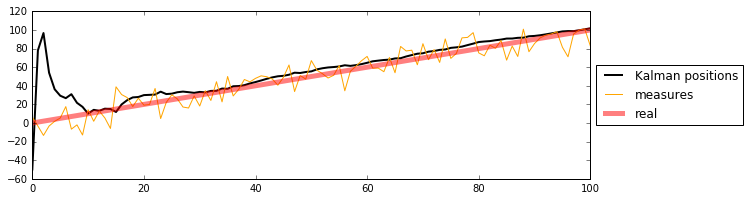

In [29]:
estimated_init_pos, estimated_init_vel  = -50., 100.

o = ConstantVelocityRobot(init_pos=0, vel=1, mnoise=10)
o.move_n_time_steps(100)
    
plot_kalman1D(o, estimated_init_pos, estimated_init_vel)

Pero si nuestro modelo físico no es correcto Kalman no puede converger

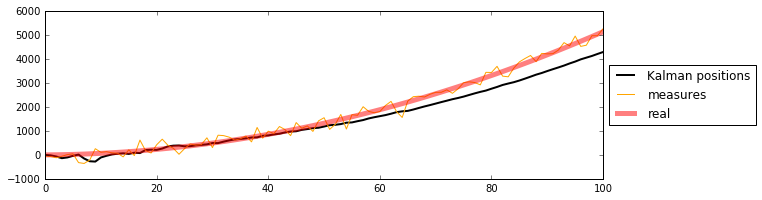

In [30]:
estimated_init_pos, estimated_init_vel  = 0,1

oa = ConstantAccelerationRobot(init_pos=0, init_vel=1, accel=1., mnoise=200)
oa.move_n_time_steps(100)

plot_kalman1D(oa, estimated_init_pos, estimated_init_vel)